### In this assignment we are going to use CIFAR10 dataset where we will have different images e.g. Airplane, Automobile, Bird, Cat etc with resolution of 32 x 32 and we will try to build our model using functional API as till now we were using Sequential API. Also, main objective of this assignment is to get used to different type of convolution.

### So we have below objectives in this assignment:
*   Use a Normal Convolution layer in our model using Functional API
*   Use a Spatially Separable Convolution layer
*   Use a Depthwise Separable Convolution
*   Use a Depthwise Separable Convolution
*   Use a Grouped Convolution (use 3x3, 5x5 only) layer
*   Use a Grouped Convolution (use 3x3 only, one with dilation = 1, and another with dilation = 2) layer

### So to achieve this goal lets first import keras library and  import all pakages and functions from keras with which we are going to build the CNN model

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D,SeparableConv2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import Input
from keras.layers.merge import concatenate
from keras.models import Model

### Now we are going to load the pre-shuffled CIFAR10 data from keras. Out of total 60k data we have 50k different class image as train data and 10k image as test data which is autometically predefined in mnist dataset. So here we have total 10 different classes of images as: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck.

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols, img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))
print(train_features.shape)
print(test_features.shape)

170500096/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


### Now let's look into some images. Here we are going to pick one image from each class randomly to see how it looks:

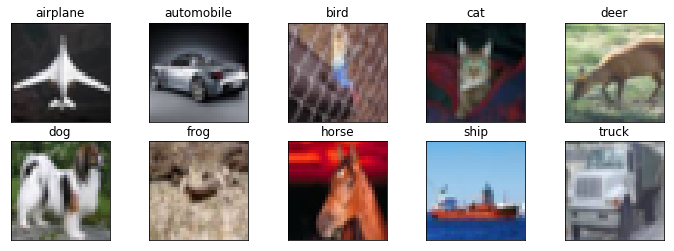

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(12,4))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

### Now here we are going to create a function which is going to plot our train and test model accuracy and losses with respect epochs.

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

### Also, here we have created one more function which is going to give us actual  test accuracy from model and test data:

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

### Now, lets scale the test and train data and change labels from 1-dimentional class matrix to 10 dimentional class matrix so that we can predict out of 10 class.

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

### Now let's build our model using functional API and lets use above mentioned different type of convolution:

In [0]:
input_layer = Input(shape=(32,32,3))

conv1 = Convolution2D(32, 3, 3, border_mode='same', activation='relu')(input_layer)
batchnorm1 = BatchNormalization()(conv1)
dropout1 = Dropout(0.15)(batchnorm1)

conv2_sp_1 = Convolution2D(32, 3, 1, border_mode='same', activation='relu')(dropout1)
conv2_sp_2 = Convolution2D(64, 1, 3, border_mode='same', activation='relu')(conv2_sp_1)
batchnorm2 = BatchNormalization()(conv2_sp_2)
dropout2 = Dropout(0.15)(batchnorm2)

conv3 = SeparableConv2D(128, 3, 3, border_mode='same', activation='relu')(dropout2)
batchnorm3 = BatchNormalization()(conv3)
dropout3 = Dropout(0.15)(batchnorm3)


conv4 = Convolution2D(32, 1, 1, activation='relu')(dropout3)
batchnorm4 = BatchNormalization()(conv4)
maxpool1 = MaxPooling2D(pool_size=(2, 2))(batchnorm4)


conv5_1 = Convolution2D(64, 3, 3, border_mode='same', activation='relu')(maxpool1)
batchnorm5_1 = BatchNormalization()(conv5_1)
dropout4_1 = Dropout(0.15)(batchnorm5_1)

conv5_2 = Convolution2D(64, 5, 5, border_mode='same', activation='relu')(maxpool1)
batchnorm5_2 = BatchNormalization()(conv5_2)
dropout4_2 = Dropout(0.15)(batchnorm5_2)

merge1 = concatenate([dropout4_1, dropout4_2])


conv6_1 = Convolution2D(128, 3, 3, border_mode='same', dilation_rate = 1, activation='relu')(merge1)
batchnorm6_1 = BatchNormalization()(conv6_1)
dropout5_1 = Dropout(0.15)(batchnorm6_1)

conv6_2 = Convolution2D(128, 3, 3, border_mode='same', dilation_rate = 2, activation='relu')(merge1)
batchnorm6_2 = BatchNormalization()(conv6_2)
dropout5_2 = Dropout(0.15)(batchnorm6_2)

merge2 = concatenate([dropout5_1, dropout5_2])


conv7 = Convolution2D(32, 1, 1, activation='relu')(merge2)
batchnorm7 = BatchNormalization()(conv7)
maxpool2 = MaxPooling2D(pool_size=(2, 2))(batchnorm7)


conv8 = Convolution2D(64, 3, 3, border_mode='same', activation='relu')(maxpool2)
batchnorm8 = BatchNormalization()(conv8)
dropout6 = Dropout(0.15)(batchnorm8)

conv9 = Convolution2D(128, 3, 3, border_mode='same', activation='relu')(dropout6)
batchnorm9 = BatchNormalization()(conv9)
dropout7 = Dropout(0.15)(batchnorm9)

conv10 = Convolution2D(10, 1, 1, activation='relu')(dropout7)
batchnorm10 = BatchNormalization()(conv10)
conv11 = Convolution2D(10, 8)(batchnorm10)

flat1 = Flatten()(conv11)
output = Activation('softmax')(flat1)
model = Model(inputs=input_layer, outputs=output)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 1), activation="relu", padding="same")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 3), activation="relu", padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(128, (3, 3), activation="relu", padding="same")`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1)

### Now let's look at the model summary, Here we can see we have total of 500k parameters to train. Now let's see how this model is going to perform

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_88 (Conv2D)              (None, 32, 32, 32)   896         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_64 (BatchNo (None, 32, 32, 32)   128         conv2d_88[0][0]                  
__________________________________________________________________________________________________
dropout_47 (Dropout)            (None, 32, 32, 32)   0           batch_normalization_64[0][0]     
__________________________________________________________________________________________________
conv2d_89 

### Now we are going to run this model for 50 epochs and let's check what training accuracy we are going to get:

In [0]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint

def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.003), metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_s

Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
195/195 [==============================] - 38s 197ms/step - loss: 1.4495 - acc: 0.4785 - val_loss: 2.6545 - val_acc: 0.3457

Epoch 00001: val_acc improved from -inf to 0.34570, saving model to best_model.hdf5
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
195/195 [==============================] - 32s 163ms/step - loss: 0.9645 - acc: 0.6550 - val_loss: 1.0044 - val_acc: 0.6572

Epoch 00002: val_acc improved from 0.34570 to 0.65720, saving model to best_model.hdf5
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
195/195 [==============================] - 32s 163ms/step - loss: 0.7607 - acc: 0.7312 - val_loss: 0.7705 - val_acc: 0.7294

Epoch 00003: val_acc improved from 0.65720 to 0.72940, saving model to best_model.hdf5
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.0015329586.
195/195 [=====================

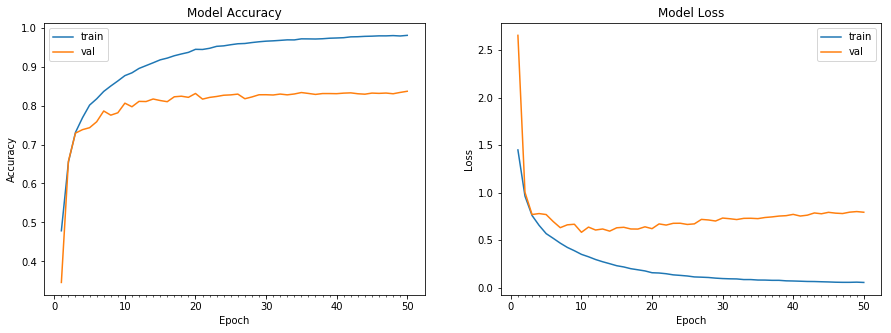

Best Accuracy on test data is: 83.69


In [0]:
# checkpoint
filepath="best_model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

from keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(zoom_range=0.0,horizontal_flip=False,
                             featurewise_center=True, featurewise_std_normalization=True)

datagen_test = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
iterator_test = datagen_test.flow(test_features, test_labels, batch_size=len(test_features), shuffle=False)
test_features_2, test_labels_2 = iterator_test.next()

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen_train.flow(train_features, train_labels, batch_size = 256),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features_2, test_labels_2), verbose=1,
                                 callbacks=[checkpoint,LearningRateScheduler(scheduler, verbose=1)])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
model.load_weights('best_model.hdf5')
print ("Best Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

### So, in the above model we can see that after introducing separable convolution, group convolution and dialiation convolution we have got best validation accuracy 83.69%